In [1]:
#Required cell: This cell needs to be executed to import the necessary libraries
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
from scipy import stats
from scipy import integrate
from IPython.display import HTML, display
from scipy.stats import norm
from scipy.stats import t as the
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
%matplotlib inline
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)

In [2]:
#Required cell: This cell needs to be executed as it contains necessary data structures
#Activity ID map
activity_id = {0: 'transient', 1:'lying', 2:'sitting', 3:'standing',
              4:'walking', 5:'running', 6:'cycling', 7:'Nordic walking',
              9:'watching TV', 10:'computer work', 11:'car driving',
              12:'ascending stairs', 13:'descending stairs', 16:'vacuum cleaning',
              17:'ironing', 18:'folding laundry', 19:'house cleaning',
              20:'playing soccer', 24:'rope jumping'}

#Protocol Activities: lie, sit, stand, walk, run, cycle, Nordic walk, iron, vacuum cleaning, 
#rope jump, ascend and descend stairs
protocol_acts = [1,2,3,4,5,6,7,17,16,24,12,13]

#Optional Activities: watch TV, computer work, drive car, fold laundry, house cleaning, play soccer
optional_acts = [9,10,11,18,19,20]

#MET Classification of activities

#lying, sitting, standing and ironing
light_acts = [1,2,3,17]
#vacuum cleaning, descending stairs, walking, Nordic walking and cycling
mod_acts = [16,13,4,7,6]
#ascending stairs, running and rope jumping
vig_acts = [12,5,24]

#Function used to classify activities
def map_met(act_id):
    if act_id in light_acts:
        return 'light'
    if act_id in mod_acts:
        return 'moderate'
    if act_id in vig_acts:
        return 'vigorous'
    
#Making list for updating column names in dataframe
col_names=['timestamp', 'activity_id', 'heart_rate']

IMU_locations = ['hand', 'chest', 'ankle']
IMU_data = ['tmp', 'acc_16_01', 'acc_16_02', 'acc_16_03',
            'acc_06_01', 'acc_06_02', 'acc_06_03',
            'gyr_01', 'gyr_02', 'gyr_03',
            'mag_01', 'mag_02', 'mag_03',
            'ori_01', 'ori_02', 'ori_03', 'ori_04']

col_names = col_names + [item for sublist in [[dat+'_'+loc for dat in IMU_data] for loc in IMU_locations] for item in sublist]

In [4]:

files = [
    'C:/HAR/PAMAP2_Dataset/Protocol/subject101.dat',
    'C:/HAR/PAMAP2_Dataset/Protocol/subject102.dat',
    'C:/HAR/PAMAP2_Dataset/Protocol/subject103.dat',
    'C:/HAR/PAMAP2_Dataset/Protocol/subject104.dat',
    'C:/HAR/PAMAP2_Dataset/Protocol/subject105.dat',
    'C:/HAR/PAMAP2_Dataset/Protocol/subject106.dat',
    'C:/HAR/PAMAP2_Dataset/Protocol/subject107.dat',
    'C:/HAR/PAMAP2_Dataset/Protocol/subject108.dat',
    'C:/HAR/PAMAP2_Dataset/Protocol/subject109.dat'
]

pamap2 = pd.DataFrame()

for file in files:
    sub_data = pd.read_table(file, header=None, sep='\s+')
    sub_data.columns = col_names
    sub_data['sub_id'] = int(file[-5])
    sub_data['act_level'] = sub_data['activity_id'].apply(map_met)
    pamap2 = pamap2.append(sub_data, ignore_index=True)

In [5]:
drop_index = []

#Getting indexes of activity 0
drop_index += list(pamap2.index[pamap2['activity_id']==0])

#Keep only activities as documented on file "PerformedActivitiesSummary.pdf"
drop_index += list(pamap2.index[(pamap2['sub_id']==1) & (pamap2['activity_id'].isin([10,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==2) & (pamap2['activity_id'].isin([9,10,11,18,19,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==3) & (pamap2['activity_id'].isin([5,6,7,9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==4) & (pamap2['activity_id'].isin([5,9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==5) & (pamap2['activity_id'].isin([9,11,18,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==6) & (pamap2['activity_id'].isin([9,11,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==7) & (pamap2['activity_id'].isin([9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==8) & (pamap2['activity_id'].isin([9,11]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==9) & (pamap2['activity_id'].isin([1,2,3,4,5,6,7,9,11,12,13,16,17]))])

pamap2 = pamap2.drop(drop_index)
    
#Interpolate data
pamap2 = pamap2.interpolate()

In [6]:
#Remove transients, 10 seconds from the start and end of each activity
freq = 100
pamap2['act_block'] = ((pamap2['activity_id'].shift(1) != pamap2['activity_id']) | (pamap2['sub_id'].shift(1) != pamap2['sub_id'])).astype(int).cumsum()
drop_index = []
numblocks = pamap2['act_block'].max()
for block in range(1, numblocks+1):
    drop_index += list(pamap2[pamap2['act_block']==block].head(10 * freq).index)
    drop_index += list(pamap2[pamap2['act_block']==block].tail(10 * freq).index)
    
pamap2 = pamap2.drop(drop_index)

In [7]:
pamap2.head()

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_level,act_block
3928,47.66,1,103.0,30.5,-7.76319,-6.59656,0.831271,-7.59876,-6.81413,0.952719,-0.023345,-0.094827,0.200758,11.67170,53.3611,-20.7827,1.0,0.0,0.0,0.0,32.3125,-1.42829,4.59099,-9.91106,-1.66712,4.60909,-9.66838,-1.69665,0.073002,0.284169,44.5122,-11.2486,51.2443,1.0,0.0,0.0,0.0,30.875,9.35603,1.448820,-3.44087,9.48208,1.661260,-3.42233,0.100157,-0.328539,0.148857,-74.7494,-45.4312,-41.3917,1.0,0.0,0.0,0.0,1,light,1
3929,47.67,1,103.0,30.5,-7.96283,-6.78714,0.559511,-7.81101,-6.84291,0.832193,0.119344,-0.173491,0.228492,10.79910,53.7261,-19.8429,1.0,0.0,0.0,0.0,32.3125,-1.30241,4.63088,-9.52170,-1.62106,4.68434,-9.59287,-1.77871,0.069577,0.317669,44.0021,-12.7925,50.8668,1.0,0.0,0.0,0.0,30.875,9.45772,1.108960,-3.74644,9.40729,1.449600,-3.33044,0.022160,-0.316792,0.150338,-76.0839,-46.1565,-41.3886,1.0,0.0,0.0,0.0,1,light,1
3930,47.68,1,103.0,30.5,-7.56159,-6.94546,0.181182,-7.78390,-6.97924,0.605953,0.293628,-0.223687,0.237504,10.24440,53.4288,-19.6083,1.0,0.0,0.0,0.0,32.3125,-1.10925,4.74376,-9.44113,-1.48431,4.77441,-9.45742,-1.75758,0.041567,0.325210,44.5969,-13.3610,49.7718,1.0,0.0,0.0,0.0,30.875,8.73577,0.508215,-4.02024,9.13637,0.920061,-3.41811,0.000155,-0.259867,0.156328,-75.4083,-45.9693,-40.6494,1.0,0.0,0.0,0.0,1,light,1
3931,47.69,1,103.0,30.5,-7.27130,-7.14018,-0.121712,-7.59227,-7.11690,0.228539,0.516965,-0.241007,0.224821,9.80950,52.9010,-18.9146,1.0,0.0,0.0,0.0,32.3125,-1.17896,5.04652,-9.24977,-1.43726,4.86454,-9.23076,-1.84174,-0.005494,0.366242,44.5062,-13.9122,49.2794,1.0,0.0,0.0,0.0,30.875,9.52078,0.959822,-4.13076,8.82006,0.798751,-3.61280,-0.003502,-0.218614,0.199243,-76.1764,-46.5085,-39.5349,1.0,0.0,0.0,0.0,1,light,1
3932,47.70,1,103.0,30.5,-7.19573,-6.95140,-0.159704,-7.24956,-7.30087,-0.058323,0.646473,-0.272410,0.216307,9.98846,52.2646,-21.0066,1.0,0.0,0.0,0.0,32.3125,-1.28709,5.23644,-9.05874,-1.48014,5.07573,-9.07876,-1.85351,-0.055315,0.391737,44.3054,-14.8072,50.1332,1.0,0.0,0.0,0.0,30.875,9.25510,0.886508,-4.24880,9.34472,1.101010,-3.90413,-0.015711,-0.279977,0.195484,-76.4170,-45.6111,-40.0185,1.0,0.0,0.0,0.0,1,light,1


In [8]:
freq = 100
windowsize = int(5.12 * freq)
displacement = 1*freq

#columns used for analysis
columns_used = ['sub_id', 'activity_id', 'act_level', 'heart_rate',
                'tmp_hand','acc_16_01_hand','acc_16_02_hand','acc_16_03_hand',
                'gyr_01_hand','gyr_02_hand','gyr_03_hand',
                'tmp_chest','acc_16_01_chest','acc_16_02_chest','acc_16_03_chest',
                'gyr_01_chest','gyr_02_chest','gyr_03_chest',
                'tmp_ankle','acc_16_01_ankle','acc_16_02_ankle','acc_16_03_ankle',
                'gyr_01_ankle','gyr_02_ankle','gyr_03_ankle']

#resting HR for participating subjects, used for normalisation
sub_rest_hr = {1:75, 2:74, 3:68, 4:58, 5:70, 6:60, 7:60, 8:66, 9:54}

windows = []

#Sliding window of 5.12 seconds, equaling 512 instances of data, with 1 second of overlap
for block in range(1, numblocks+1):
    ar = np.array(pamap2[pamap2['act_block']==block][columns_used])
    start_index = 0
    while True:
        if len(ar[start_index:start_index+windowsize,:])<512:
            break
        windows.append(ar[start_index:start_index+windowsize,:])
        start_index += displacement

#Next the features for each window are calculated
window_features = []
for window in windows:
    features = []
    #Adding Subject ID, Activity ID and Activity Level for ground truth
    features.append(window[0][0])
    features.append(window[0][1])
    features.append(window[0][2])
    #Computing mean, normalised mean and std for HR data
    features.append(np.mean(window[:,3]))
    features.append(np.mean(window[:,3]/sub_rest_hr[window[0][0]]))
    features.append(np.std(window[:,3]))
    features.append(np.std(window[:,3]/sub_rest_hr[window[0][0]]))
    #Computing mean and std for the rest of the columns
    for col in range(4,25):
        features.append(np.mean(window[:,col]))
        features.append(np.std(window[:,col]))
    #Computing correlation between axes for hand Accelerometer    
    features.append(stats.spearmanr(window[:,5],window[:,6])[0])
    features.append(stats.spearmanr(window[:,6],window[:,7])[0])
    features.append(stats.spearmanr(window[:,5],window[:,7])[0])
    #Computing correlation between axes for chest Accelerometer  
    features.append(stats.spearmanr(window[:,12],window[:,13])[0])
    features.append(stats.spearmanr(window[:,13],window[:,14])[0])
    features.append(stats.spearmanr(window[:,12],window[:,14])[0])
    #Computing correlation between axes for ankle Accelerometer
    features.append(stats.spearmanr(window[:,19],window[:,20])[0])
    features.append(stats.spearmanr(window[:,20],window[:,21])[0])
    features.append(stats.spearmanr(window[:,19],window[:,21])[0])
    #Computing correlation between axes for hand Gyroscope    
    features.append(stats.spearmanr(window[:,8],window[:,9])[0])
    features.append(stats.spearmanr(window[:,9],window[:,10])[0])
    features.append(stats.spearmanr(window[:,8],window[:,10])[0])
    #Computing correlation between axes for chest Gyroscope  
    features.append(stats.spearmanr(window[:,15],window[:,16])[0])
    features.append(stats.spearmanr(window[:,16],window[:,17])[0])
    features.append(stats.spearmanr(window[:,15],window[:,17])[0])
    #Computing correlation between axes for ankle Gyroscope
    features.append(stats.spearmanr(window[:,22],window[:,23])[0])
    features.append(stats.spearmanr(window[:,23],window[:,24])[0])
    features.append(stats.spearmanr(window[:,22],window[:,24])[0])
    window_features.append(features)

#new dataframe with features for each window
features = pd.DataFrame(window_features)

In [9]:
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66
0,1,1,light,103.951172,1.386016,0.805429,0.010739,30.523682,0.030320,-1.879247,3.534154,4.788385,2.567330,6.990495,1.965119,0.107901,0.466133,-0.251155,0.366370,0.211265,0.456911,32.323120,0.023473,1.521597,1.132801,5.122803,3.014503,5.573594,5.041338,-0.487434,0.561027,-0.086311,0.294916,0.101015,0.336984,30.900513,0.030719,2.413188,3.686631,-7.901836,3.011201,-4.319748,1.431167,-0.027212,0.486969,0.053937,0.474670,0.407518,0.913272,0.464139,0.055267,0.510214,0.511312,-0.799051,-0.302004,0.264226,-0.113223,0.314868,-0.531362,-0.581758,0.530794,0.230082,-0.481656,-0.604763,0.325803,-0.294619,-0.170427
1,1,1,light,104.509766,1.393464,0.952667,0.012702,30.535889,0.030904,-0.185149,1.377860,5.695728,0.972648,7.785865,0.751240,-0.009273,0.381659,-0.113646,0.258900,0.043581,0.215902,32.335327,0.030093,1.475562,1.023636,3.805870,2.555193,8.036729,2.391985,-0.255809,0.411611,0.009638,0.174810,-0.005376,0.236450,30.912720,0.030573,0.609043,1.205205,-8.821382,1.874376,-4.609152,1.303216,-0.045085,0.330023,0.014152,0.202536,0.046104,0.258117,0.028908,-0.684904,0.096735,0.619179,-0.638843,-0.491480,-0.427727,-0.389651,0.486994,-0.282832,-0.248817,0.230088,-0.118856,-0.139842,-0.481102,0.194234,-0.368513,-0.292237
2,1,1,light,105.253906,1.403385,1.094676,0.014596,30.548096,0.026321,0.319354,0.447698,5.626324,0.819042,7.950312,0.582057,-0.037028,0.274945,-0.016048,0.083449,-0.029576,0.083680,32.347534,0.031020,1.085746,0.737306,2.650548,1.082055,9.169791,0.582381,-0.111460,0.330841,0.024648,0.143875,-0.048026,0.205479,30.924927,0.025055,0.226354,1.141336,-8.691025,1.764263,-4.796809,1.227335,-0.031455,0.262951,-0.013533,0.102034,0.037852,0.237697,0.129201,-0.685796,-0.184500,0.190822,-0.328401,-0.034166,-0.562640,-0.522007,0.588619,-0.162304,0.219523,0.154424,-0.130829,-0.111774,-0.385171,0.214233,-0.311803,-0.179082
3,1,1,light,105.839844,1.411198,1.069291,0.014257,30.555542,0.019659,0.322273,0.326337,5.483047,0.568834,8.098098,0.372352,0.029006,0.152585,0.000316,0.055307,-0.006781,0.042133,32.359741,0.026849,0.875531,0.400173,2.274730,0.498286,9.317323,0.253320,-0.035471,0.129909,-0.000624,0.093716,0.017624,0.097199,30.937134,0.004770,-0.141292,0.981405,-8.506603,1.748027,-5.133278,1.202987,-0.051114,0.199645,-0.012446,0.088246,0.053858,0.207330,0.134870,-0.670430,-0.109069,-0.280928,-0.168570,0.215786,-0.328764,-0.544402,0.499454,-0.300674,0.085189,-0.138638,0.257661,-0.379470,-0.646042,0.187620,-0.438468,-0.192798
4,1,1,light,106.339844,1.417865,0.853795,0.011384,30.558350,0.015562,0.316246,0.102791,5.702229,0.209482,7.966321,0.143267,0.009624,0.092451,0.001428,0.025731,-0.010280,0.025021,32.371948,0.013469,0.958177,0.216285,2.088273,0.369734,9.364349,0.213946,-0.006847,0.072573,-0.006268,0.058533,-0.006317,0.067592,30.937500,0.000000,-0.584390,0.345254,-8.254930,1.697411,-5.647530,0.819204,-0.053999,0.155904,-0.009388,0.079133,0.039167,0.198324,-0.089136,-0.450723,0.222441,-0.109808,-0.121974,0.081106,0.164706,-0.425811,0.105384,-0.167682,0.148621,-0.260610,0.276035,-0.401572,-0.531046,0.008690,-0.389506,-0.293527


In [10]:
#Generating column list for features dataset
feature_names = ['sub_id','activity_id','act_level','hr_mean','hr_mean_normal','hr_std', 'hr_std_normal']
locs = ['hand','chest','ankle']
cols = ['tmp','acc_x','acc_y','acc_z', 'gyr_x','gyr_y','gyr_z']
feats = ['mean','std']

for loc in locs:
    for col in cols:
        for feat in feats:
            feature_names.append(loc + '_' + col + '_' + feat)
for loc in locs:
    feature_names += [loc + '_acc_xy_cor', loc + '_acc_yz_cor', loc + '_acc_xz_cor']

for loc in locs:
    feature_names += [loc + '_gyr_xy_cor', loc + '_gyr_yz_cor', loc + '_gyr_xz_cor']

features.columns = feature_names

#Using a seed to facilitate replication of results
dev_data_df = features.sample(frac=0.7, random_state=1)
test_data_df = features.drop(dev_data_df.index)

In [11]:
dev_data_df.head()

,sub_id,activity_id,act_level,hr_mean,hr_mean_normal,hr_std,hr_std_normal,hand_tmp_mean,hand_tmp_std,hand_acc_x_mean,hand_acc_x_std,hand_acc_y_mean,hand_acc_y_std,hand_acc_z_mean,hand_acc_z_std,hand_gyr_x_mean,hand_gyr_x_std,hand_gyr_y_mean,hand_gyr_y_std,hand_gyr_z_mean,hand_gyr_z_std,chest_tmp_mean,chest_tmp_std,chest_acc_x_mean,chest_acc_x_std,chest_acc_y_mean,chest_acc_y_std,chest_acc_z_mean,chest_acc_z_std,chest_gyr_x_mean,chest_gyr_x_std,chest_gyr_y_mean,chest_gyr_y_std,chest_gyr_z_mean,chest_gyr_z_std,ankle_tmp_mean,ankle_tmp_std,ankle_acc_x_mean,ankle_acc_x_std,ankle_acc_y_mean,ankle_acc_y_std,ankle_acc_z_mean,ankle_acc_z_std,ankle_gyr_x_mean,ankle_gyr_x_std,ankle_gyr_y_mean,ankle_gyr_y_std,ankle_gyr_z_mean,ankle_gyr_z_std,hand_acc_xy_cor,hand_acc_yz_cor,hand_acc_xz_cor,chest_acc_xy_cor,chest_acc_yz_cor,chest_acc_xz_cor,ankle_acc_xy_cor,ankle_acc_yz_cor,ankle_acc_xz_cor,hand_gyr_xy_cor,hand_gyr_yz_cor,hand_gyr_xz_cor,chest_gyr_xy_cor,chest_gyr_yz_cor,chest_gyr_xz_cor,ankle_gyr_xy_cor,ankle_gyr_yz_cor,ankle_gyr_xz_cor
3006,2,17,light,87.000000,1.175676,0.000000,7.105427e-15,34.3750,0.0,-1.165524,2.383779,3.381285,2.582771,8.492507,1.224852,0.093030,0.719383,-0.080050,0.494687,-0.170838,0.980066,37.750000,0.000000,-0.574081,0.956643,8.924554,0.575753,-4.355411,0.852119,0.052130,0.172671,-0.127863,0.550284,0.069405,0.261474,35.1250,0.0,9.613680,0.141006,-2.034883,0.449276,-0.675058,0.722426,0.003878,0.260395,-0.039163,0.099164,0.003677,0.141914,0.614900,-0.749890,-0.252158,-0.096426,0.451917,-0.137126,0.291370,-0.242012,0.233251,-0.472662,0.335516,-0.377507,-0.290138,-0.779952,0.071855,-0.305959,-0.003001,-0.638866
3497,2,4,moderate,124.605469,1.683858,0.927920,1.253946e-02,31.8750,0.0,-12.040995,3.734766,3.069947,2.591651,1.161251,1.837110,0.055998,2.159256,-0.031960,0.962742,0.089741,3.720493,36.500000,0.000000,0.526051,2.046854,8.318571,2.496176,-5.332919,2.201650,0.022321,0.314681,-0.036313,0.806525,-0.011805,0.666682,34.5625,0.0,11.712190,5.814112,0.068395,7.408032,-1.578947,3.224426,-0.089607,1.419706,-0.109581,0.823423,-0.033989,3.099118,-0.238044,-0.186898,0.162161,-0.007312,-0.513200,0.059846,0.128946,-0.270560,-0.119772,-0.287380,-0.230390,-0.491314,0.011124,-0.799319,-0.135736,-0.653133,-0.654575,0.391363
14495,7,5,vigorous,113.493430,1.891557,2.315888,3.859813e-02,32.5000,0.0,-3.723040,10.188184,11.705779,17.220389,-1.367870,4.527840,0.186308,2.657634,0.321703,2.115963,-0.036559,2.807273,36.756836,0.019507,0.740500,3.648823,9.913660,11.646691,-0.689218,3.454264,0.064076,0.904309,0.242770,1.406050,-0.009270,0.686093,32.0000,0.0,14.272593,19.002270,4.774907,16.373748,-4.488213,13.319767,0.268098,2.850637,-0.214467,1.461636,0.173994,4.399006,-0.226895,-0.685601,0.441670,-0.033515,0.167499,-0.246121,-0.083889,0.418781,0.025673,-0.265566,0.824691,-0.121345,-0.004923,-0.317761,-0.202148,-0.660278,-0.528138,0.402147
13278,7,17,light,82.513672,1.375228,0.492657,8.210948e-03,33.8125,0.0,-3.618932,1.935690,0.542981,2.907890,8.430229,0.975924,-0.163251,0.502349,0.209826,0.456587,0.271169,0.886100,36.750000,0.000000,0.185189,1.393045,9.358609,0.220221,-3.092576,0.264225,0.003291,0.064052,0.034760,0.096851,-0.095510,0.132262,32.8125,0.0,9.280206,0.111226,-0.821241,0.193480,-3.597638,0.332495,0.007408,0.061254,0.007822,0.044353,0.009165,0.047432,0.435401,0.031484,0.092153,-0.458219,0.108914,-0.342861,-0.274557,-0.555554,0.724061,-0.196728,0.315984,-0.380337,0.284190,-0.109078,-0.071734,-0.177813,0.237828,-0.729771
14969,8,3,light,73.000000,1.106061,0.000000,7.327472e-15,34.4375,0.0,-9.275877,0.082824,1.006239,0.153816,2.709588,0.155286,-0.008753,0.049173,0.002632,0.025952,-0.001796,0.027531,37.562500,0.000000,-1.116647,0.108927,9.665873,0.098028,0.706836,0.171972,0.010735,0.044164,0.004822,0.046422,-0.016413,0.019973,34.1250,0.0,6.686333,0.077043,-7.266617,0.080816,-1.471347,0.167118,-0.000961,0.039025,0.000421,0.028817,0.005620,0.017938,0.221818,-0.077456,0.344009,0.069912,0.031856,0.127825,0.468236,-0.292715,-0.001651,-0.

Dev Dataset by Activity


ascending stairs     1539
walking              1525
standing             1220
lying                1203
Nordic walking       1196
sitting              1162
rope jumping         1099
cycling              1035
running               593
ironing               522
vacuum cleaning       428
descending stairs     251
Name: Activity Counts, dtype: int64

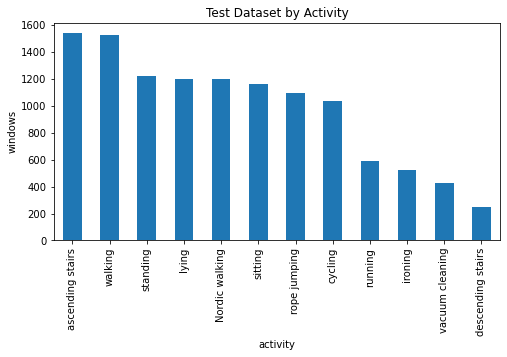

In [12]:
s = dev_data_df.groupby('activity_id').count()['act_level']
s = s.rename("Activity Counts")
s.index = [activity_id[x] for x in protocol_acts]
print(('Dev Dataset by Activity'))
display(s.sort_values(ascending =False))
ax = s.sort_values(ascending =False).plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('windows')
_ = ax.set_xlabel('activity')
_ = ax.set_title('Test Dataset by Activity') 

Dev Dataset by Activity Intensity Level


act_level
light       5124
moderate    5283
vigorous    1366
Name: Activity Level Counts, dtype: int64

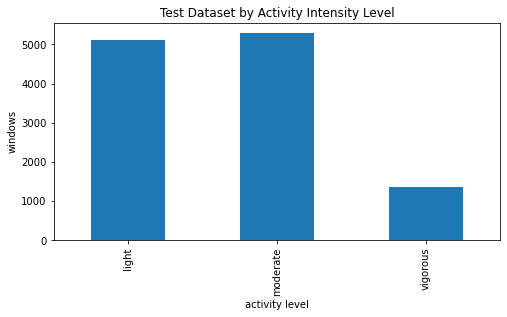

In [13]:
s = dev_data_df.groupby('act_level').count()['activity_id']
s = s.rename("Activity Level Counts")
print(('Dev Dataset by Activity Intensity Level'))
display(s)
ax = s.plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('windows')
_ = ax.set_xlabel('activity level')
_ = ax.set_title('Test Dataset by Activity Intensity Level') 

In [14]:
def plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=True, showannot=False):
    """Function used to plot heatmap using input dataframe"""
    mycmap = LinearSegmentedColormap.from_list('mycmap', ['lightgreen', 'tomato'])
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    _ = sns.heatmap(df, cmap = mycmap, yticklabels=yticks, xticklabels=xticks, square=True,\
                    linewidths=0.01, cbar=showcbar, annot=showannot,fmt='.1f')
    _ = ax.set_ylabel(ylabel)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_title(title)
    
def plot_series(df, feat, location, act, unit, pylim):
    plottitle = location + ' ' + feat + ' - ' + act
    plotx = location.lower() + '_' + feat.lower()[0:3] + '_x_mean'
    ploty = location.lower() + '_' + feat.lower()[0:3] + '_y_mean'
    plotz = location.lower() + '_' + feat.lower()[0:3] + '_z_mean'
    ax1 = df.plot(x=df.index,y=plotx, color='r', figsize=(12,5), ylim=pylim)
    _ = df.plot(x=df.index,y=ploty, color='g', ax=ax1)
    _ = df.plot(x=df.index,y=plotz, color='b', ax=ax1)
    _ = ax1.set_title(plottitle)
    _ = ax1.set_xlabel('window')
    _ = ax1.set_ylabel(unit)

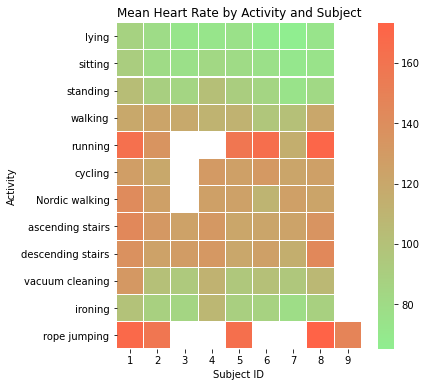

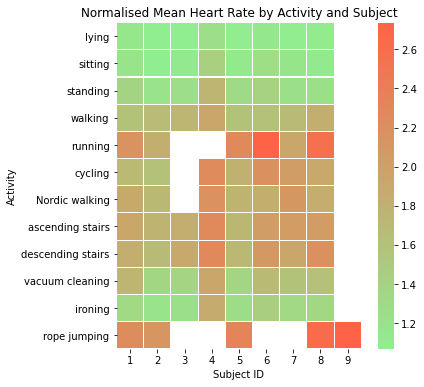

In [15]:
yticks = [y for x, y in activity_id.items() if x in protocol_acts]
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Activity'
xlabel = 'Subject ID'

title = 'Mean Heart Rate by Activity and Subject'
df = dev_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hr_mean']].pivot(index='activity_id', columns='sub_id', values='hr_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Normalised Mean Heart Rate by Activity and Subject'
df = dev_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hr_mean_normal']].pivot(index='activity_id', columns='sub_id', values='hr_mean_normal')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

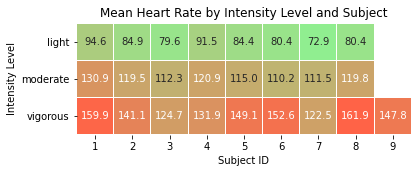

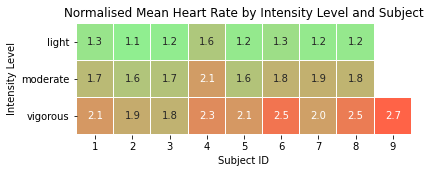

In [16]:
df = dev_data_df.groupby(['act_level','sub_id'], as_index=False).mean() \
            [['act_level','sub_id','hr_mean']].pivot(index='act_level', columns='sub_id', values='hr_mean')
    
yticks = ['light','moderate','vigorous']
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Intensity Level'
xlabel = 'Subject ID'
title = 'Mean Heart Rate by Intensity Level and Subject'
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=False, showannot=True)

df = dev_data_df.groupby(['act_level','sub_id'], as_index=False).mean() \
            [['act_level','sub_id','hr_mean_normal']].pivot(index='act_level', columns='sub_id', values='hr_mean_normal')
title = 'Normalised Mean Heart Rate by Intensity Level and Subject'
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=False, showannot=True)

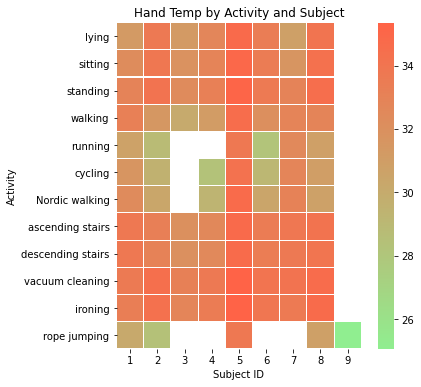

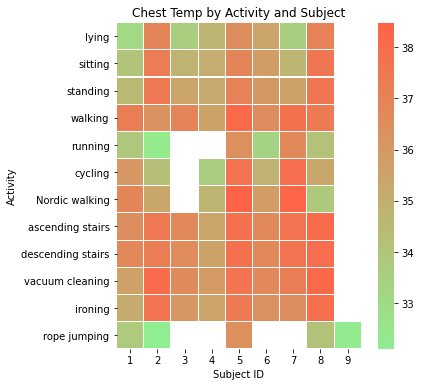

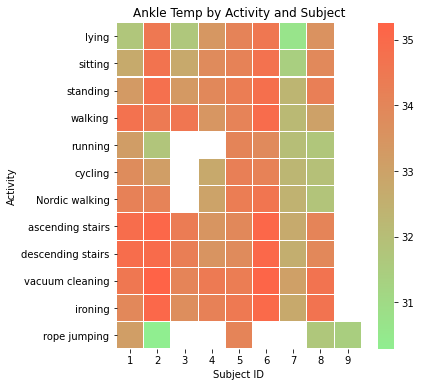

In [17]:
yticks = [y for x, y in activity_id.items() if x in protocol_acts]
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Activity'
xlabel = 'Subject ID'

title = 'Hand Temp by Activity and Subject'
df = dev_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hand_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='hand_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Chest Temp by Activity and Subject'
df = dev_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','chest_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='chest_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Ankle Temp by Activity and Subject'
df = dev_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','ankle_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='ankle_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

In [23]:
df1=dev_data_df[dev_data_df['activity_id']==1]
df2=dev_data_df[dev_data_df['activity_id']==4]
df3=dev_data_df[dev_data_df['activity_id']==5]

feat = 'Accelerometer'
unit = 'ms^-2'
pylimit = (-25,25)

In [24]:
plot_series(df1, feat, 'Hand', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Hand', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Hand', 'Running', unit, pylimit)

plot_series(df1, feat, 'Chest', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Chest', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Chest', 'Running', unit, pylimit)

plot_series(df1, feat, 'Ankle', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Ankle', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Ankle', 'Running', unit, pylimit)

KeyError: "None of [Int64Index([ 7942,   231, 14713,  2219,    22, 10490, 14551,  2320,  6071,\n             4553,\n            ...\n            12609,   151, 10505, 12513, 12621, 12706, 12656,  2236, 12694,\n             4513],\n           dtype='int64', length=1203)] are in the [columns]"

In [21]:
df1=dev_data_df[dev_data_df['activity_id']==1]
df2=dev_data_df[dev_data_df['activity_id']==4]
df3=dev_data_df[dev_data_df['activity_id']==5]

feat = 'Gyroscope'
unit = 'rad/s'
pylimit = (-1.5,1.5)

plot_series(df1, feat, 'Hand', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Hand', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Hand', 'Running', unit, pylimit)

plot_series(df1, feat, 'Chest', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Chest', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Chest', 'Running', unit, pylimit)

plot_series(df1, feat, 'Ankle', 'Lying', unit, pylimit)
plot_series(df2, feat, 'Ankle', 'Walking', unit, pylimit)
plot_series(df3, feat, 'Ankle', 'Running', unit, pylimit)

KeyError: "None of [Int64Index([ 7942,   231, 14713,  2219,    22, 10490, 14551,  2320,  6071,\n             4553,\n            ...\n            12609,   151, 10505, 12513, 12621, 12706, 12656,  2236, 12694,\n             4513],\n           dtype='int64', length=1203)] are in the [columns]"

In [25]:
class meandiffanalysis:
    """
    This class is used to perform a statistical analysis of the difference of means between two samples. 
    It receives a dictionary with the statistics of each of the samples, namely  mean, median, std, total items and 
    name.
    
    The class has several methods that use these statistics to calculate the difference between the sample means,
    as well as the p-values using either normal or t distributions.
    
    Each method displays its result as HTML to create more visually attractive output.
    """   
    
    def __init__(self, datadict):
        """Assign dicitionary values to local variables"""
        self.sam1 = datadict['sam1']
        self.sam2 = datadict['sam2']
        self.mean1 = datadict['mean1']
        self.median1 = datadict['median1']
        self.std1 = datadict['std1']
        self.count1 = datadict['count1']
        self.mean2 = datadict['mean2']
        self.median2 = datadict['median2']
        self.std2 = datadict['std2']
        self.count2 = datadict['count2']
        self.nullhyp = datadict['nullhyp']
    
    def displaystattable(self):
        """Displays a table with the basic statistics of the two samples being compared"""
        display(HTML("<table><tr><th></th><th>Mean</th><th>Median</th><th>Std Dev</th><th>Count</th></tr>"
                 "<tr><th>{}</th><td>{:,.4f}</td><td>{:,.4f}</td><td>{:,.4f}</td><td>{:,}</td></tr>"
                 "<tr><th>{}</th><td>{:,.4f}</td><td>{:,.4f}</td><td>{:,.4f}</td><td>{:,}</td></tr></table><br>"
                 .format(self.sam1, self.mean1, self.median1, self.std1, self.count1, self.sam2, self.mean2, self.median2, self.std2, self.count2)))
    
    def displayhypotheses(self):
        """Displays the null and alternative hypotheses"""
        display(HTML("<b>Null Hypothesis</b><br>H<sub>0</sub>: μ<sub>1</sub> -  μ<sub>2</sub> = {}".format(self.nullhyp)))
        display(HTML("<b>Alternative Hypothesis</b><br>H<sub>1</sub>: μ<sub>1</sub> -  μ<sub>2</sub> > {}".format(self.nullhyp)))
    
    def displaymeandiff_normal(self):
        """Calculates and displays the difference between the mans of two samples"""
        diff = self.mean1-self.mean2
        comberr = np.sqrt(self.std1**2/self.count1 + self.std2**2/self.count2)
        self.zval = diff/comberr
        display(HTML("<b>Difference between means</b><br>"
                "D ~ N (μ<sub>1</sub> - μ<sub>2</sub> , "
                 "&#x03C3<sub>1</sub><sup>2</sup> / n<sub>1</sub> + "
                 "&#x03C3<sub>2</sub><sup>2</sup> / n<sub>2</sub>)<br>"
                 "P(D ≥ {}) = P( Z ≥ {} / √( "
                 "&#x03C3<sub>1</sub><sup>2</sup> / n<sub>1</sub> + "
                 "&#x03C3<sub>2</sub><sup>2</sup> / n<sub>2</sub>) )<br>"
                 "P(D ≥ {}) = P( Z ≥ {})".format(diff,diff,diff,self.zval)))
    
    def displaypvalue_normal(self):
        """Calculates and displays p-value using the normal distribution"""
        pval = 1 - norm.cdf(self.zval)
        display(HTML("<b>P-value of difference using normal distribution</b><br>{}".format(pval)))
    
    def displaymeandiff_t(self):
        """Calculates and displays the difference between the mans of two samples using t-test"""
        diff = self.mean1-self.mean2
        df = self.count1 + self.count2 - 2
        pools = np.sqrt((((self.count1-1)*self.std1**2) + ((self.count2-1)*self.std2**2))/df)
        se = pools * np.sqrt(1/self.count1 + 1/self.count2)
        self.tval = diff / se         
        display(HTML("<b>Two-sample T-test</b><br>"
                "DF = (n<sub>1</sub> + n<sub>2</sub> - 2 ) <br>"
                "DF = {}<br><br>"
                "s = √ ((n<sub>1</sub>-1)s<sub>1</sub><sup>2</sup> + (n<sub>2</sub>-1)s<sub>2</sub><sup>2</sup> / DF )<br>"
                "s = {}<br><br>"
                "SE = s * √ ( 1 / n<sub>1</sub> + 1 / n<sub>2</sub> )<br>"
                "SE = {}<br><br>"
                "Diff = μ<sub>1</sub> - μ<sub>2</sub><br>"
                "Diff = {}<br><br>"
                "t-statistic = Diff / SE<br>"
                "t-statistic = {}<br>".format(df, pools, se, diff, self.tval)))
        
    def displaypvalue_t(self):
        """Calculates and displays p-value using the t distribution."""
        df = self.count1 + self.count2 - 2
        pval = 1 - the.cdf(self.tval, df)
        display(HTML("<b>P-value of difference using T distribution</b><br>{}".format(pval)))

In [26]:
df = test_data_df
df['act_level'] = df['activity_id'].apply(map_met)

#The following two samples of genre will be compared
sam1 = 'moderate'
sam2 = 'light'

#Create dictionary with the necessary statistics to perform the calculation
datadict = {}
datadict['sam1'] = sam1
datadict['sam2'] = sam2
datadict['mean1'] = df[df.act_level==sam1].hr_mean_normal.mean()
datadict['median1'] = df[df.act_level==sam1].hr_mean_normal.median()
datadict['std1'] = df[df.act_level==sam1].hr_mean_normal.std()
datadict['count1'] = df[df.act_level==sam1].hr_mean_normal.count()
datadict['mean2'] = df[df.act_level==sam2].hr_mean_normal.mean()
datadict['median2'] = df[df.act_level==sam2].hr_mean_normal.median()
datadict['std2'] = df[df.act_level==sam2].hr_mean_normal.std()
datadict['count2'] = df[df.act_level==sam2].hr_mean_normal.count()
datadict['nullhyp'] = 0

#Display statistics
h1a=meandiffanalysis(datadict)
h1a.displaystattable()

,Mean,Median,Std Dev,Count
moderate,1.7849,1.7498,0.2510,"2,279"
light,1.2725,1.2414,0.2030,"2,151"


In [27]:
h1a.displayhypotheses()
h1a.displaymeandiff_normal()
h1a.displaypvalue_normal()

In [28]:
df = test_data_df
df['act_level'] = df['activity_id'].apply(map_met)

#The following two samples of genre will be compared
sam1 = 'vigorous'
sam2 = 'moderate'

#Create dictionary with the necessary statistics to perform the calculation
datadict = {}
datadict['sam1'] = sam1
datadict['sam2'] = sam2
datadict['mean1'] = df[df.act_level==sam1].hr_mean_normal.mean()
datadict['median1'] = df[df.act_level==sam1].hr_mean_normal.median()
datadict['std1'] = df[df.act_level==sam1].hr_mean_normal.std()
datadict['count1'] = df[df.act_level==sam1].hr_mean_normal.count()
datadict['mean2'] = df[df.act_level==sam2].hr_mean_normal.mean()
datadict['median2'] = df[df.act_level==sam2].hr_mean_normal.median()
datadict['std2'] = df[df.act_level==sam2].hr_mean_normal.std()
datadict['count2'] = df[df.act_level==sam2].hr_mean_normal.count()
datadict['nullhyp'] = 0

#Display statistics
h1b=meandiffanalysis(datadict)
h1b.displaystattable()

,Mean,Median,Std Dev,Count
vigorous,2.2105,2.1893,0.3727,616
moderate,1.7849,1.7498,0.2510,"2,279"


In [29]:
#Display analysis results
h1b.displayhypotheses()
h1b.displaymeandiff_normal()
h1b.displaypvalue_normal()

Test Dataset by Activity


walking              668
ascending stairs     650
lying                525
Nordic walking       513
sitting              493
standing             483
rope jumping         458
cycling              437
ironing              257
running              242
vacuum cleaning      203
descending stairs    117
Name: Activity Counts, dtype: int64

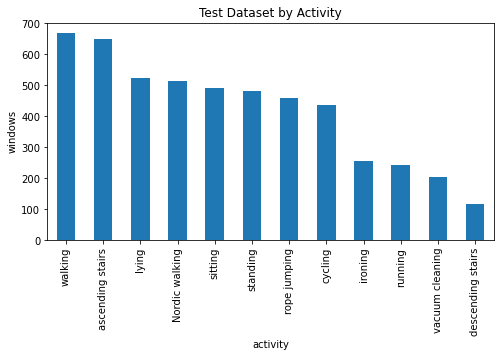

In [30]:
s = test_data_df.groupby('activity_id').count()['act_level']
s = s.rename("Activity Counts")
s.index = [activity_id[x] for x in protocol_acts]
print(('Test Dataset by Activity'))
display(s.sort_values(ascending =False))
ax = s.sort_values(ascending =False).plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('windows')
_ = ax.set_xlabel('activity')
_ = ax.set_title('Test Dataset by Activity') 

Test Dataset by Activity Intensity Level


act_level
light       2151
moderate    2279
vigorous     616
Name: Activity Level Counts, dtype: int64

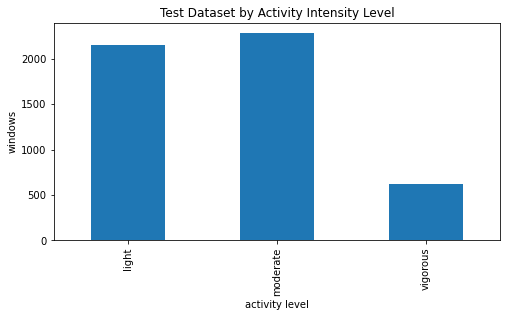

In [31]:
s = test_data_df.groupby('act_level').count()['activity_id']
s = s.rename("Activity Level Counts")
print(('Test Dataset by Activity Intensity Level'))
display(s)
ax = s.plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('windows')
_ = ax.set_xlabel('activity level')
_ = ax.set_title('Test Dataset by Activity Intensity Level') 

In [49]:
test_data_df.describe()

,sub_id,activity_id,hr_mean,hr_mean_normal,hr_std,hr_std_normal,hand_tmp_mean,hand_tmp_std,hand_acc_x_mean,hand_acc_x_std,hand_acc_y_mean,hand_acc_y_std,hand_acc_z_mean,hand_acc_z_std,hand_gyr_x_mean,hand_gyr_x_std,hand_gyr_y_mean,hand_gyr_y_std,hand_gyr_z_mean,hand_gyr_z_std,chest_tmp_mean,chest_tmp_std,chest_acc_x_mean,chest_acc_x_std,chest_acc_y_mean,chest_acc_y_std,chest_acc_z_mean,chest_acc_z_std,chest_gyr_x_mean,chest_gyr_x_std,chest_gyr_y_mean,chest_gyr_y_std,chest_gyr_z_mean,chest_gyr_z_std,ankle_tmp_mean,ankle_tmp_std,ankle_acc_x_mean,ankle_acc_x_std,ankle_acc_y_mean,ankle_acc_y_std,ankle_acc_z_mean,ankle_acc_z_std,ankle_gyr_x_mean,ankle_gyr_x_std,ankle_gyr_y_mean,ankle_gyr_y_std,ankle_gyr_z_mean,ankle_gyr_z_std,hand_acc_xy_cor,hand_acc_yz_cor,hand_acc_xz_cor,chest_acc_xy_cor,chest_acc_yz_cor,chest_acc_xz_cor,ankle_acc_xy_cor,ankle_acc_yz_cor,ankle_acc_xz_cor,hand_gyr_xy_cor,hand_gyr_yz_cor,hand_gyr_xz_cor,chest_gyr_xy_cor,chest_gyr_yz_cor,chest_gyr_xz_cor,ankle_gyr_xy_cor,ankle_gyr_yz_cor,ankle_gyr_xz_cor
count,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000
mean,4.567182,7.919937,106.927438,1.618433,0.620876,0.009508,32.761520,0.010951,-4.942754,2.985041,3.507952,3.355167,3.732188,2.011457,-0.003304,1.036098,0.044660,0.676066,-0.003084,1.174837,36.166267,0.011127,0.334922,1.154836,8.028685,2.456031,-1.382337,1.437885,0.005509,0.312422,0.015390,0.384944,-0.024270,0.244465,33.697955,0.010463,9.355941,3.748412,-0.240438,4.904131,-2.652089,2.504154,0.014454,0.835191,-0.036513,0.462427,0.008466,1.443081,0.013410,0.030261,-0.025881,0.082818,0.013177,0.055833,0.085247,-0.102950,0.052538,-0.155315,-0.001384,-0.164079,-0.047534,-0.186203,-0.161452,-0.094245,-0.028988,0.034080
std,2.317115,6.164955,26.555741,0.411472,0.539332,0.008433,1.765130,0.012797,4.702730,3.059917,4.359122,4.330293,2.973435,1.667935,0.272537,0.838656,0.184571,0.669453,0.156301,1.142859,1.486808,0.012768,0.941868,0.897250,2.924349,3.291919,4.561132,1.293619,0.043442,0.324793,0.196982,0.360444,0.070640,0.189850,1.092988,0.012635,3.630677,4.255220,3.499420,5.261461,1.664088,2.627831,0.195305,0.750248,0.126648,0.442179,0.091893,1.497854,0.340843,0.389045,0.326677,0.232468,0.376792,0.263223,0.232428,0.307137,0.314199,0.329397,0.457812,0.305523,0.217986,0.331269,0.228761,0.328728,0.496906,0.308750
min,1.000000,1.000000,57.000000,0.982759,0.000000,0.000000,24.983765,0.000000,-24.123314,0.056700,-14.605581,0.055163,-8.236639,0.087788,-1.765292,0.019015,-0.722071,0.018673,-0.903257,0.014420,31.993774,0.000000,-4.070448,0.056605,-2.248834,0.054905,-10.149587,0.088039,-0.487434,0.019635,-1.204935,0.019365,-0.420700,0.015291,30.125000,0.000000,-1.262755,0.046824,-9.840345,0.048067,-10.069933,0.083147,-1.047834,0.021591,-0.627596,0.020247,-0.407946,0.014115,-0.879615,-0.919723,-0.894994,-0.874955,-0.961742,-0.907171,-0.825808,-0.930825,-0.853671,-0.924937,-0.973199,-0.873602,-0.806866,-0.942768,-0.937755,-0.857645,-0.937148,-0.947303
25%,2.000000,3.000000,85.866211,1.270832,0.342872,0.005104,31.632996,0.000000,-8.756180,0.616022,1.955498,0.871882,1.722565,0.765610,-0.066241,0.353756,-0.010908,0.175466,-0.052700,0.188778,35.169891,0.000000,0.006494,0.295313,8.089212,0.199617,-4.288626,0.333006,-0.004820,0.086607,-0.014357,0.098570,-0.032

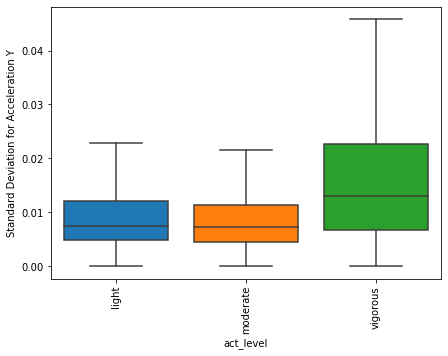

In [57]:
# TEST CODE

plt.figure(figsize=(7,5))
sns.boxplot(x='act_level', y='hr_std_normal', data=test_data_df, showfliers=False, saturation=1)
plt.ylabel('Standard Deviation for Acceleration Y')
plt.xticks(rotation=90)
plt.show()

In [32]:
def confusion_matrix(predict_labels, real_labels, cats, title):
    """
    Function used to display confusion matrix from a set of predicted and real labels. Displays a confusion matrix,
    then uses sklearn library utilities to calculate accuracy, precision, recall and F-score from the data.
    
    Params:
    predict_labels: array of labels predicted by model
    real_labels: array of real labels
    cats: categories for rows and columns of confusion matrix. If false, activity data from protocol activities are used.
    title: title of confusion matrix.
    
    """ 
    pred_results = {}
    base_dict = {}
    
    #If cats parameter is False, the matrix is created with activity data from protocol activities
    if not cats:
        for i in protocol_acts:
            base_dict[i]=0
        for i in protocol_acts:
            pred_results[i] = base_dict.copy()
    else:
        for i in cats:
            base_dict[i]=0
        for i in cats:
            pred_results[i] = base_dict.copy()
    
    #Dictionary is created counting real values for predicted labels
    for pl,tl in list(zip(predict_labels,  real_labels)):
        pred_results[pl][tl]+=1

    pred_results_df = pd.DataFrame(pred_results)
    if not cats:
        pred_results_df.columns=[activity_id[x] for x in protocol_acts]
        pred_results_df.index = [activity_id[x] for x in protocol_acts]
    
    #Accuracy, precision, recall and f-score are calculated using sklearn library
    precision = precision_score(real_labels, predict_labels, average='macro')
    recall = recall_score(real_labels, predict_labels, average='macro')
    accuracy = accuracy_score(real_labels, predict_labels)
    fscore = f1_score(real_labels, predict_labels, average='macro')
    
    #Display results
    print((title))
    display((pred_results_df))
    print(('Accuracy: ' + str(accuracy)))
    print(('Precision: ' + str(precision)))
    print(('Recall: ' + str(recall)))
    print(('F-score: ' + str(fscore)))    

In [33]:
tclf = tree.DecisionTreeClassifier()

features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal']
label_col = 'act_level'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, ['light','moderate','vigorous'], "Confusion Matrix for Decision Tree using HR features only")

Confusion Matrix for Decision Tree using HR features only


,light,moderate,vigorous
light,2016,132,3
moderate,140,2002,137
vigorous,5,159,452


Accuracy: 0.8858501783590963
Precision: 0.8565023224078013
Recall: 0.8498200634708057
F-score: 0.8530582784115661


In [34]:
vclf = svm.SVC()

features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal']
label_col = 'act_level'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
vclf.fit(train_data, train_labels)

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = vclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, ['light','moderate','vigorous'], "Confusion Matrix for SVM using HR features only")

Confusion Matrix for SVM using HR features only


,light,moderate,vigorous
light,1892,259,0
moderate,274,1966,39
vigorous,2,319,295


Accuracy: 0.8230281411018628
Precision: 0.8429086673365886
Recall: 0.7403820176156186
F-score: 0.7708138588562331


In [35]:
features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal',
                    'hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std'
                ]
label_col = 'act_level'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, ['light','moderate','vigorous'], "Confusion Matrix for Decision Tree using HR  and Accelerometer features")

Confusion Matrix for Decision Tree using HR  and Accelerometer features


,light,moderate,vigorous
light,2128,23,0
moderate,6,2259,14
vigorous,0,24,592


Accuracy: 0.9867221561632976
Precision: 0.984568151739218
Recall: 0.9805234937064394
F-score: 0.9825075914360407


In [36]:
features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal',
                    'hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std'
                ]
label_col = 'act_level'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
vclf.fit(train_data, train_labels)

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = vclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, ['light','moderate','vigorous'], "Confusion Matrix for SVM using HR and Accelerometer features")

Confusion Matrix for SVM using HR and Accelerometer features


,light,moderate,vigorous
light,2117,34,0
moderate,26,2227,26
vigorous,0,179,437


Accuracy: 0.9474831549742371
Precision: 0.9481389619916749
Recall: 0.8902639859413181
F-score: 0.9132934390108235


"""
First, a decision tree classifier will be trained using features extracted from accelerometer readings. These features are: mean, standard deviation and correlation of axis pairings of each axis for every sensor location, for a total of 27 features. Using this training set, the decision tree classifier is able to reach an accuracy of 0.9795, with comparable levels of precision and recall. This demonstrates using only accelerometer data allows for very good classification performance
"""

In [37]:
features_used = ['hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'hand_acc_xy_cor','hand_acc_yz_cor','hand_acc_xz_cor','chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor'
                ]
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Accelerometer features")

Confusion Matrix for Decision Tree using Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,485,3,0,0,0,0,4,0,0,0,1
standing,0,4,472,0,0,2,0,4,1,0,0,0
walking,0,0,0,656,0,0,5,0,0,0,3,4
running,0,0,0,0,242,0,0,0,0,0,0,0
cycling,0,1,0,0,0,424,0,0,8,0,2,2
Nordic walking,0,0,0,0,0,0,509,0,0,0,3,1
ironing,0,3,12,0,0,2,0,628,5,0,0,0
vacuum cleaning,1,1,2,0,0,7,0,10,435,0,1,1
rope jumping,0,0,0,0,2,0,0,0,0,115,0,0


Accuracy: 0.9787950852160127
Precision: 0.9777103529786033
Recall: 0.9793718715230918
F-score: 0.9784914964015741


In [ ]:
"""
Next, the decision tree classifier is trained using features extracted from gyroscope readings. 
The feature set is very similar to the previous one, but applied to the gyroscope data found in the dataset: mean, standard deviation and correlation of axis pairings of each axis for every sensor location, for a total of 27 featues.
With this training set, the decision tree classifier is only able to reach an accuracy of 0.8973, which while a resonably good level of performance, is considerably lower than that of the accelerometer, and not ideal for the application considered in this report, and
""""

In [38]:
features_used = ['hand_gyr_x_mean','hand_gyr_x_std','hand_gyr_y_mean','hand_gyr_y_std','hand_gyr_z_mean','hand_gyr_z_std',
                    'chest_gyr_x_mean','chest_gyr_x_std','chest_gyr_y_mean','chest_gyr_y_std','chest_gyr_z_mean','chest_gyr_z_std',
                    'ankle_gyr_x_mean','ankle_gyr_x_std','ankle_gyr_y_mean','ankle_gyr_y_std','ankle_gyr_z_mean','ankle_gyr_z_std',
                    'hand_gyr_xy_cor','hand_gyr_yz_cor','hand_gyr_xz_cor','chest_gyr_xy_cor','chest_gyr_yz_cor','chest_gyr_xz_cor',
                    'ankle_gyr_xy_cor','ankle_gyr_yz_cor','ankle_gyr_xz_cor']
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Gyroscope features")

Confusion Matrix for Decision Tree using Gyroscope features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,446,57,16,0,0,1,0,2,3,0,0,0
sitting,44,397,44,0,0,0,0,4,4,0,0,0
standing,19,32,396,0,0,1,0,28,7,0,0,0
walking,0,0,0,654,0,0,9,0,0,1,4,0
running,0,0,0,0,241,0,0,0,0,0,0,1
cycling,3,1,3,0,0,414,0,0,13,0,3,0
Nordic walking,0,0,0,5,0,0,506,0,0,0,0,2
ironing,11,13,61,0,0,1,0,536,28,0,0,0
vacuum cleaning,4,2,6,3,0,10,0,32,393,3,3,2
rope jumping,0,0,0,0,0,1,0,0,1,115,0,0


Accuracy: 0.9005152596115735
Precision: 0.9124589451143463
Recall: 0.9157713561877615
F-score: 0.9138364657880528


In [ ]:
"""
Finally, a test is performed employing a training set composed of both accelerometer and gyroscope features, to measure the performance impact of using both sets of sensors. This means a total of 54 features is used to train the decision tree classifier.

Surprisingly, using this new training set, the classifier only reaches an accuracy of 0.9819, a marginal improvement over the 0.9795 reached when it was trained using only accelerometer data. The addition of the gyroscope data had an effectively negligible effect on the classifier's performance. From this, it can be concluded that, at least with the current selection of features, the addition of a gyroscope sensor to an accelerometer does not produce enough gains to justify its use.
"""

In [39]:
features_used = ['hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'hand_acc_xy_cor','hand_acc_yz_cor','hand_acc_xz_cor','chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor',
                 'hand_gyr_x_mean','hand_gyr_x_std','hand_gyr_y_mean','hand_gyr_y_std','hand_gyr_z_mean','hand_gyr_z_std',
                    'chest_gyr_x_mean','chest_gyr_x_std','chest_gyr_y_mean','chest_gyr_y_std','chest_gyr_z_mean','chest_gyr_z_std',
                    'ankle_gyr_x_mean','ankle_gyr_x_std','ankle_gyr_y_mean','ankle_gyr_y_std','ankle_gyr_z_mean','ankle_gyr_z_std',
                    'hand_gyr_xy_cor','hand_gyr_yz_cor','hand_gyr_xz_cor','chest_gyr_xy_cor','chest_gyr_yz_cor','chest_gyr_xz_cor',
                    'ankle_gyr_xy_cor','ankle_gyr_yz_cor','ankle_gyr_xz_cor'
                ]
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Accelerometer and Gyroscope features")

Confusion Matrix for Decision Tree using Accelerometer and Gyroscope features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,483,4,0,0,1,0,5,0,0,0,0
standing,0,3,473,0,0,0,0,7,0,0,0,0
walking,0,0,0,662,0,0,3,0,0,0,2,1
running,0,0,0,0,242,0,0,0,0,0,0,0
cycling,0,0,0,0,0,430,0,2,5,0,0,0
Nordic walking,0,0,0,3,0,0,508,0,0,0,2,0
ironing,0,8,8,0,0,0,0,629,5,0,0,0
vacuum cleaning,0,2,2,0,0,3,1,6,443,0,0,1
rope jumping,0,0,0,0,0,0,0,0,0,116,0,1


Accuracy: 0.9823622671422909
Precision: 0.9837562490747596
Recall: 0.9824116045059211
F-score: 0.9830718370275512


In [44]:
"""
For the first test, features extracted from accelerometer readings from a sensor located 
in the subject's hand are used to train a decision tree classifier. 
These features are mean, standard deviation and correlation of each pairing of the axes, 
a total of 9 features. Using this training set, the classifier reaches an accuracy of 0.9215, 
which is very good performance
"""

"\nFor the first test, features extracted from accelerometer readings from a sensor located \nin the subject's hand are used to train a decision tree classifier. \nThese features are mean, standard deviation and correlation of each pairing of the axes, \na total of 9 features. Using this training set, the classifier reaches an accuracy of 0.9215, \nwhich is very good performance\n"

In [40]:
features_used = ['hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'hand_acc_xy_cor','hand_acc_yz_cor','hand_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Hand Accelerometer features")

Confusion Matrix for Decision Tree using Hand Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,512,8,2,0,0,0,0,0,3,0,0,0
sitting,7,461,10,0,0,0,0,14,0,1,0,0
standing,3,7,443,4,0,1,0,9,11,0,3,2
walking,0,0,6,639,0,1,0,1,9,0,9,3
running,0,0,0,0,241,0,0,0,0,1,0,0
cycling,0,0,0,0,0,412,0,13,6,0,0,6
Nordic walking,0,0,1,2,0,0,506,0,4,0,0,0
ironing,2,19,3,0,0,12,0,594,14,1,1,4
vacuum cleaning,0,2,18,11,0,4,2,22,371,1,14,13
rope jumping,0,0,0,1,2,0,0,1,0,113,0,0


Accuracy: 0.9219183511692429
Precision: 0.9179762409845899
Recall: 0.9129044531191307
F-score: 0.9152103394282735


In [ ]:
"""
In the next test, the same feature set is used to train the classifier,
except the data are extracted from the chest sensor.
With this training set, the classifier reaches an accuracy of 0.9288, 
slightly better than that achieved with the hand sensor data. 
Interestingly, recall and F-score have a more marked improvement in comparison
"""

In [41]:
features_used = ['chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Chest Accelerometer features")

Confusion Matrix for Decision Tree using Chest Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,524,0,1,0,0,0,0,0,0,0,0,0
sitting,4,431,42,0,0,1,0,12,3,0,0,0
standing,2,47,415,0,0,2,0,17,0,0,0,0
walking,0,0,0,629,0,0,21,0,0,0,12,6
running,0,0,0,0,238,0,0,0,0,3,0,1
cycling,0,2,0,0,0,426,0,1,7,0,1,0
Nordic walking,0,0,0,16,0,0,490,0,0,0,3,4
ironing,0,12,27,0,0,1,0,586,24,0,0,0
vacuum cleaning,0,10,2,1,0,9,0,17,416,0,2,1
rope jumping,0,0,0,0,3,0,0,0,0,114,0,0


Accuracy: 0.928458184700753
Precision: 0.9319526410413436
Recall: 0.9322664339688257
F-score: 0.9320348322655533


In [45]:
"""
Finally, the test is repeated using the feature set extracted from the ankle accelerometer data. 
This time, the classifier reaches an accuracy of 0.9036, lower than the other two locations
"""

'\nFinally, the test is repeated using the feature set extracted from the ankle accelerometer data. \nThis time, the classifier reaches an accuracy of 0.9036, lower than the other two locations\n'

In [42]:
features_used = ['ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(dev_data_df.loc[:, features_used])
train_labels = np.array(dev_data_df.loc[:, label_col])
tclf.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

predict_labels = tclf.predict(test_data)
confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Ankle Accelerometer features")

Confusion Matrix for Decision Tree using Ankle Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,455,9,0,0,2,0,17,10,0,0,0
standing,0,16,386,0,0,0,0,64,17,0,0,0
walking,0,0,0,625,0,0,40,0,1,0,1,1
running,0,0,0,0,240,0,0,0,0,1,0,1
cycling,0,1,1,0,0,422,0,0,9,0,4,0
Nordic walking,0,0,0,22,0,0,489,0,0,0,1,1
ironing,0,17,65,0,0,0,0,501,67,0,0,0
vacuum cleaning,0,6,12,1,0,1,0,43,393,0,1,1
rope jumping,0,0,0,0,3,0,0,0,0,111,2,1


Accuracy: 0.90764962346413
Precision: 0.9191943047441394
Recall: 0.9187774996512452
F-score: 0.918728209960434
